# *Coded Aperture Comparison*
**Author:** Hyunmo Kang, Dong-Ha Shin | **Last Updated:** 2025-03-19

`Coded apertures` are specialized optical elements that modulate incoming light using a `patterned mask` instead of a conventional lens. They are particularly useful in lensless optical systems and are often employed in high-energy beam imaging, such as X-rays and gamma rays, where diffraction through a lens is not feasible.

In this tutorial, we will implement and simulate different types of coded apertures, including:

- **Fresnel Zone Plate**: A diffractive optical element that focuses light through alternating transparent and opaque concentric rings.
- **Pinhole Camera**: A simple imaging system that forms an image by allowing light to pass through a small aperture.
- **Uniform Redundant Array (URA)**: A structured mask designed for improved image reconstruction by maximizing light throughput and minimizing artifacts.

Through these implementations, we will explore how `coded apertures` influence imaging and signal reconstruction.

In [2]:
cd ../..

c:\Users\PC\Desktop\pado


## 🌊 **Step 1: Import Pado**
First, you should import `Pado`. Make sure to install all the dependency.

In [3]:
import pado
from pado.math import nm, um, mm, m

import torch
import numpy as np
from matplotlib import pyplot as plt

In [4]:
R = 1024  # number of rows
C = 1024  # number of columns

pitch = 2 * um  # physical size of each pixel in [m]
wvl = 550 * nm  # wavelength of the light in [m]
dim = (1, 1, R, C)  # dimension of the light [batch, channel, row, column]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

propagator = pado.propagator.Propagator('ASM')

print(f'device: {device}')

device: cuda


## 🔬 **Step 2: Fresnel Zone Plate**

`Fresnel zone plate` focuses light to a single point. Unlike lenses or curved mirrors, zone plates use diffraction instead of refraction or reflection. To get constructive interference at the focus, the zones should switch from `opaque` to `transparent` at radii where:

### $r_n = \sqrt{n\lambda f + \frac{1}{4}n^2 \lambda^2}$

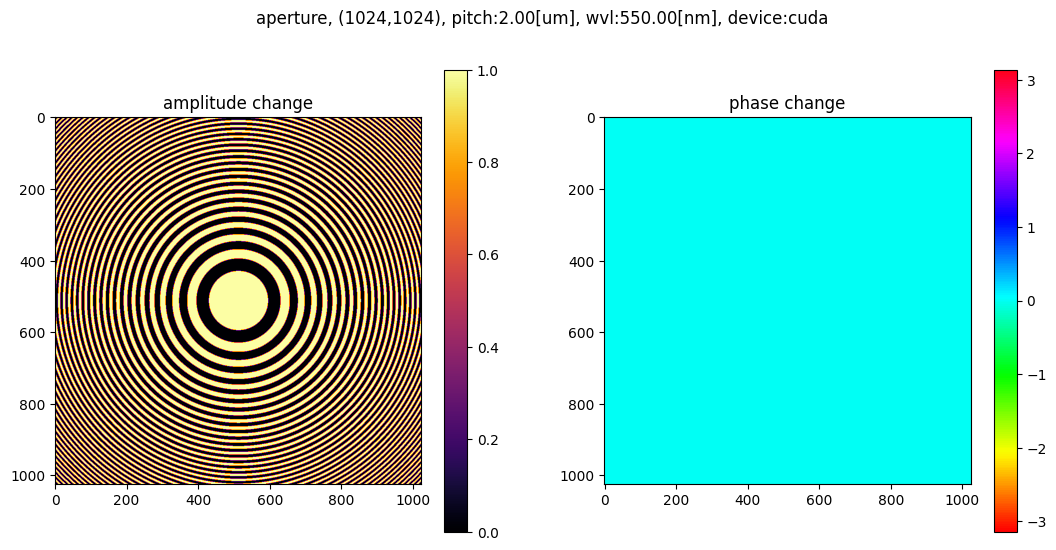

In [5]:
def fresnel_mask(R, C, f):
    """
    Generates a Fresnel zone plate mask.

    Parameters:
    R (int): Number of rows in the output mask.
    C (int): Number of columns in the output mask.
    f (float): Focal length parameter used for computing Fresnel zones.

    Returns:
    torch.Tensor: A 2D tensor of shape (R, C) representing the Fresnel mask,
                  where values alternate between 0 and 1 in concentric circular zones.
    """
    ret = np.zeros((R, C))

    x = np.linspace(-C//2, C//2, C) * pitch
    y = np.linspace(-R//2, R//2, R) * pitch

    xx, yy = np.meshgrid(x, y)
    rr = np.sqrt(xx ** 2 + yy ** 2)
    rn = lambda x: np.sqrt(x * wvl * f + 0.25 * (x * wvl) ** 2)
    N = np.ceil((-f + np.sqrt(f ** 2 + max(R * pitch, C * pitch) ** 2)) / wvl)

    for k in range(int(N) + 1):
        ret[(rn(2 * k) < rr) & (rr < rn(2 * k + 1))] = 1

    return torch.Tensor(ret)

f = 50 * mm
mask = fresnel_mask(R, C, f)

fresnel_zone_plate = pado.optical_element.Aperture((1, 1, R, C), pitch, 0, 'circle', wvl, device=device)
fresnel_zone_plate.set_amplitude_change(mask.to(device))
fresnel_zone_plate.visualize()

Now, let’s examine how light behaves after passing through a `Fresnel Zone Plate` at different observation distances. We assume that the light source is effectively at infinity, arriving from a distance of **5 meters**. 

In [6]:
def simulate_fzp(d, dx=0, dy=0):
    """
    Simulates light propagation through a Fresnel Zone Plate (FZP).

    Parameters:
    d (float): Distance from the Fresnel Zone Plate to the observation plane.
    dx (float, optional): Lateral displacement of the light source along the x-axis (default is 0).
    dy (float, optional): Lateral displacement of the light source along the y-axis (default is 0).

    Returns:
    torch.Tensor: A normalized intensity distribution at the observation plane after propagation.
    """
    light = pado.light.Light(dim, pitch, wvl, device=device)
    light.set_spherical_light(5, dx, dy)

    out = fresnel_zone_plate.forward(light)
    out = propagator.forward(out, d)
    out = out.get_intensity()
    out /= out.sum()
    return out

Unlike a standard lens, a binary zone plate produces intensity maxima along the axis of the plate at `odd fractions` **(f/3, f/5, f/7, etc.)**. Although these contain less energy than the principal focus because it is wider, they have the same maximum intensity

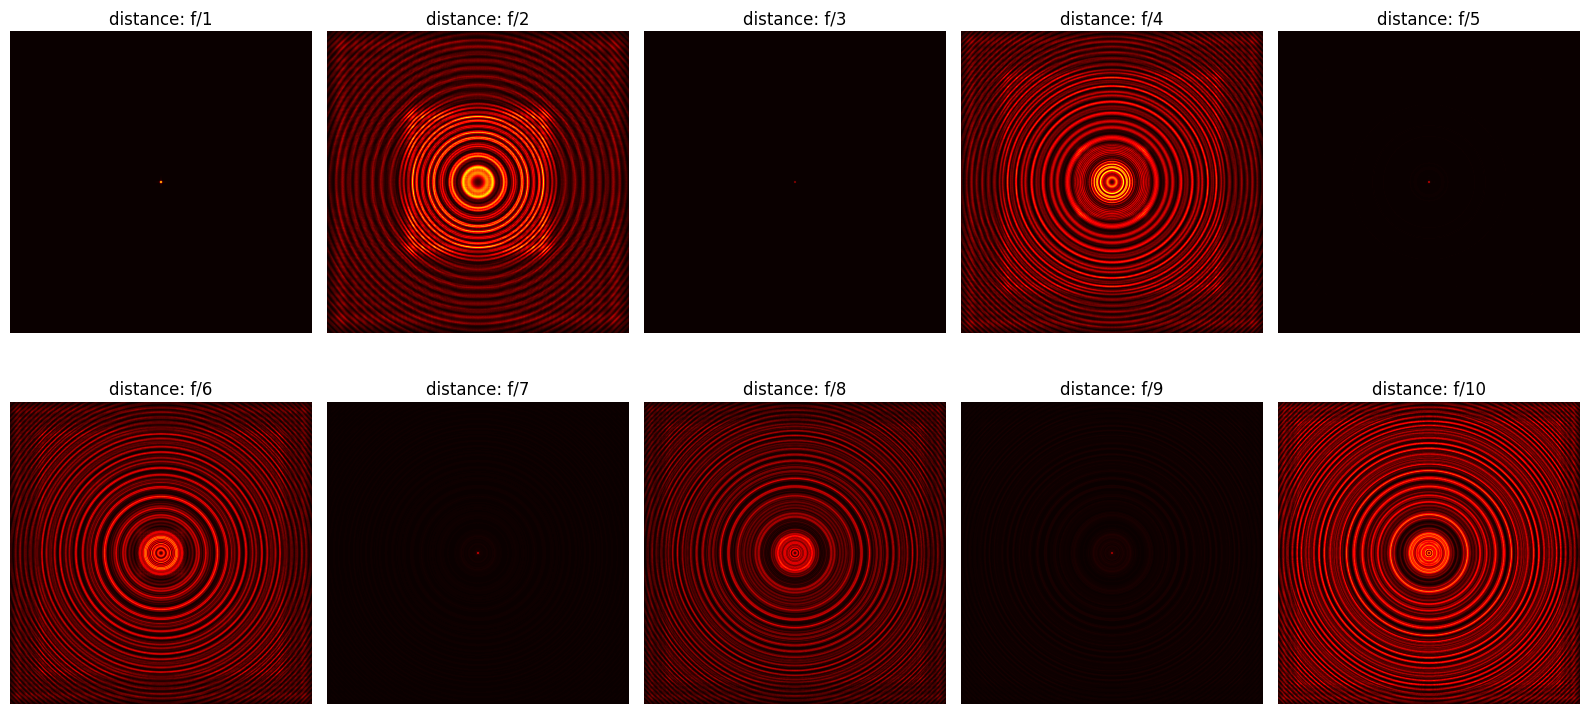

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i in range(10):
    ax = axes[i // 5, i % 5]

    im = ax.imshow(simulate_fzp(f / (1 + i)).cpu().squeeze(), cmap='hot')
    ax.axis('off')
    ax.set_title('distance: f/{}'.format(i + 1))

plt.tight_layout()
plt.show()

## 🕳️ **Step 3: Pinhole Camera Experiment**

In this step, we will experiment with a `pinhole camera`. The pinhole camera operates based on the principle that light passing through a very small `aperture` forms an image on the image plane.  


The diameter of the pinhole is generally given by:

### $d = \sqrt{2 \cdot f \cdot \lambda}$

where 
$d$ is the pinhole diameter,
$f$ is the focal length,
$\lambda$ is the wavelength of light.


 
To simulate a small pinhole diameter, **$f$ should be as small as possible**. However, due to the **diffraction limit**, $f$ must be at least:

### $f \geq \frac{R}{2} \frac{1}{\tan(\arcsin(\lambda / 2p))}$

where 
**$p$** refers to the pixel pitch or sensor resolution.

These constraints ensure a balance between **sharpness and diffraction effects** in the pinhole camera.

In [8]:
def calc_min_depth(R, wvl, pitch):
    """
    Calculates the minimum depth where diffraction becomes significant.

    According to the diffraction angle formula:
        angle = arcsin(wvl / (2 * pitch))
    The minimum depth is derived from geometric optics, ensuring the simulation
    captures diffraction effects correctly.

    Parameters:
    R (int): Grid size (number of pixels).
    wvl (float): Wavelength of light.
    pitch (float): Pixel pitch (sampling resolution).

    Returns:
    float: The calculated minimum depth for diffraction analysis.
    """
    return 0.5 * R * pitch / np.tan(np.arcsin(wvl / (2 * pitch)))

def simulate_diffraction(n, pitch):
    """
    Simulates a spherical wave and verifies
    the correctness of the calculated minimum diffraction depth.

    The function models diffraction by:
      1. Creating a light source.
      2. Applying a circular aperture.
      3. Propagating the wave and measuring the intensity distribution.
      4. Comparing diffraction effects at different depths up to the computed min depth.

    Parameters:
    n (int): Grid size (n x n) for the simulation.
    pitch (float): Pixel spacing.

    Returns:
    tuple:
        - result (ndarray): A 2D array storing the maximum intensity values at various depths.
        - min_depth (float): The minimum depth where diffraction is significant.
    """
    light = pado.Light((1, 1, n, n), pitch, wvl)

    aperature = pado.optical_element.Aperture((1, 1, n, n), pitch, 2 * pitch, 'circle', wvl)
    aperture_out = aperature.forward(light)

    min_depth = calc_min_depth(n, wvl, pitch)

    result = np.zeros((n, n))

    for i, z in enumerate(np.linspace(0, min_depth, n)):
        out = propagator.forward(aperture_out, z)
        out = out.get_intensity().squeeze().numpy().max(axis=1)
        result[:, i] = out

    return result, min_depth

Now, let's visualize the `maximum diffraction angle`.

minimum depth: 0.09087470940760883


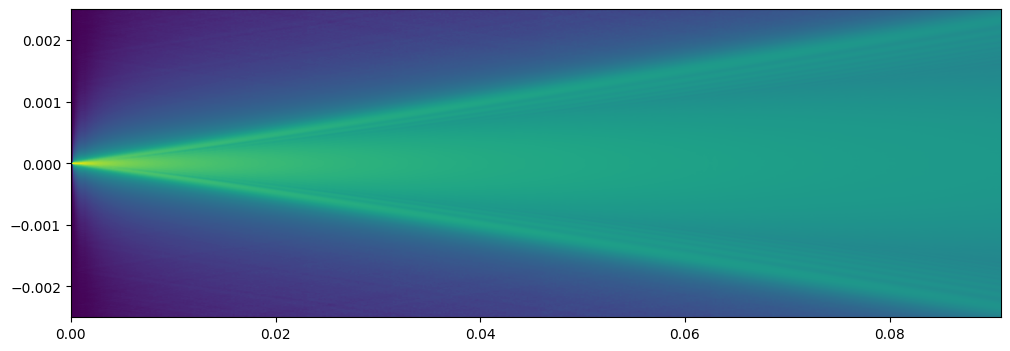

In [9]:
n = 500
pitch = 10 * um

result, depth = simulate_diffraction(n, pitch)

print(f'minimum depth: {depth}')

plt.figure(figsize=(12, 4))
plt.imshow(np.log(result + 1e-9), 
           extent=[0, depth, -n / 2  * pitch, n / 2 * pitch],
           aspect='auto')
plt.show()

Next, we will experiment with how a `pinhole camera` forms an image. To do this, let's define the field used in the experiment. We will use a plane shaped like the uppercase letter **F**.

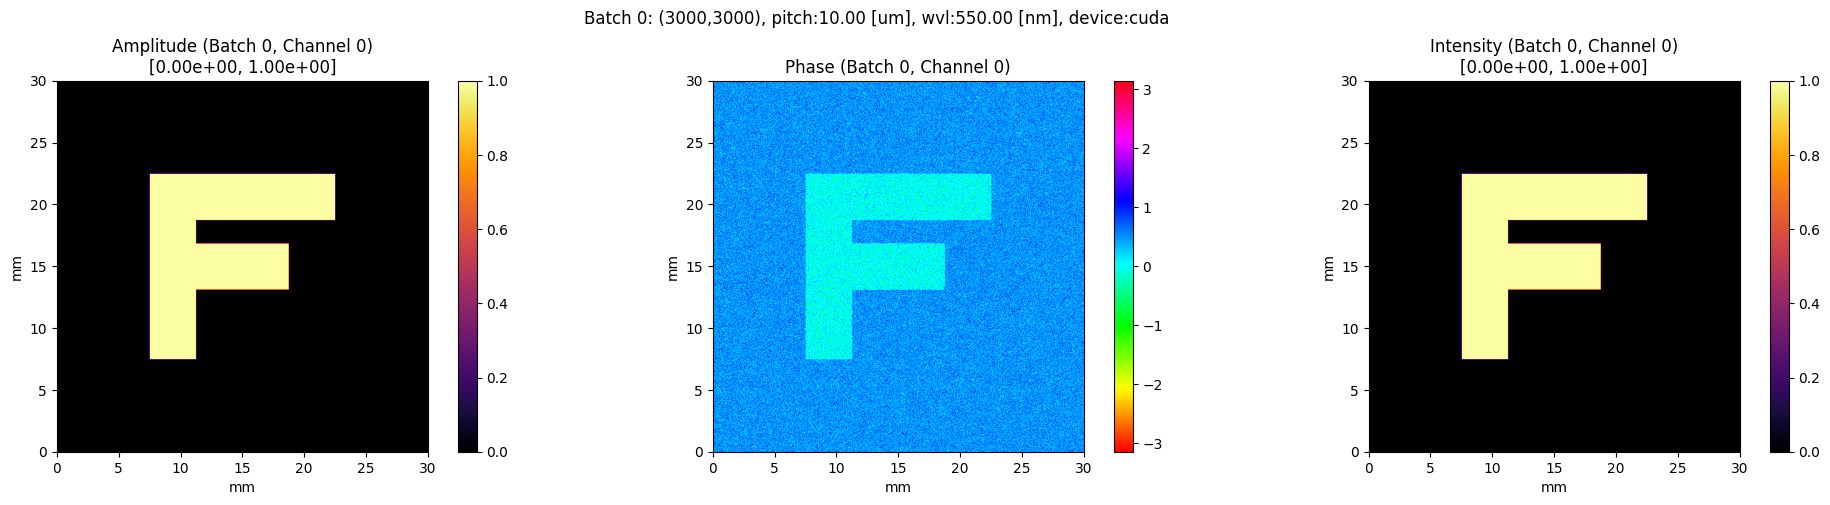

In [10]:
def generate_f_tensor(n, scale=4):
    """
    Generates a structured 2D tensor with "F" shaped patterns.

    Parameters:
    n (int): The size of the square tensor (n x n).
    scale (int, optional): Controls the size of the generated pattern (default is 4).

    Returns:
    torch.Tensor: A 4D tensor of shape (1, 1, n, n), suitable for deep learning models.
    """
    amplitude = torch.zeros((n, n))
    center = n // 2 
    pattern_scale = n // scale
    amplitude[center-pattern_scale:center+pattern_scale, center-pattern_scale:center-pattern_scale//2] = 1.0
    amplitude[center-pattern_scale:center-pattern_scale//2, center-pattern_scale:center+pattern_scale] = 1.0
    amplitude[center-pattern_scale//4:center+pattern_scale//4, center-pattern_scale:center+pattern_scale//2] = 1.0

    return amplitude[None, None]

R, C = 3000, 3000
pitch = 10 * um

object = generate_f_tensor(R)
object_light = pado.light.Light((1, 1, R, C), pitch, wvl, object.to(device), device=device)
object_light.set_phase_random()
object_light.visualize()

The aperture should satisfies the equation:

### $d = \sqrt{2 \cdot f \cdot \lambda}$

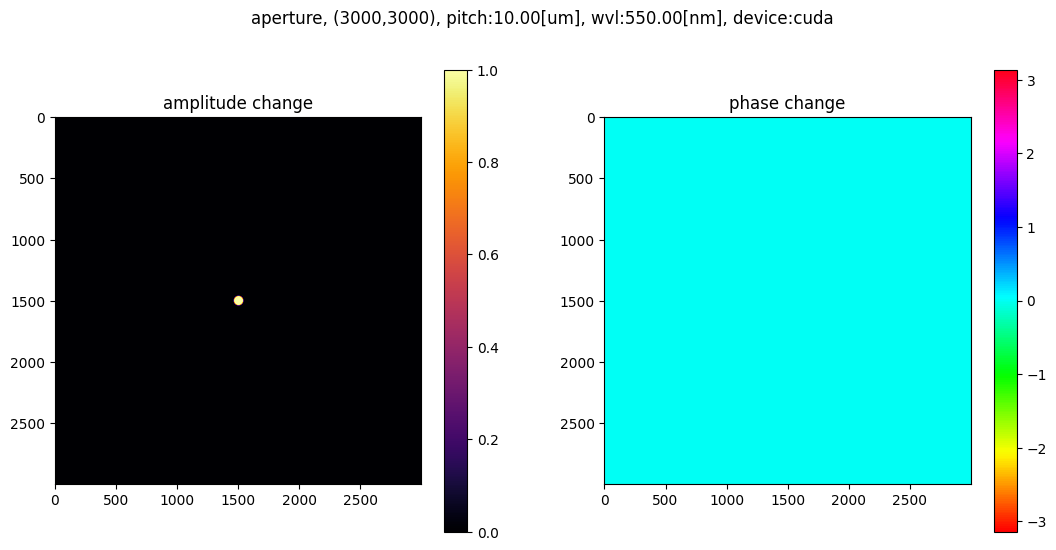

In [11]:
minimum_distance = calc_min_depth(R, wvl, pitch)
object_distance = minimum_distance
image_distance = minimum_distance

pinhole_diameter = np.sqrt(2 * image_distance * wvl)
pinhole = pado.optical_element.Aperture(
    (1, 1, R, C), 
    pitch, 
    pinhole_diameter, 
    'circle', 
    wvl, 
    device=device)

pinhole.visualize()

Now, let's pass the defined light through the pinhole camera and observe the resulting image formation.

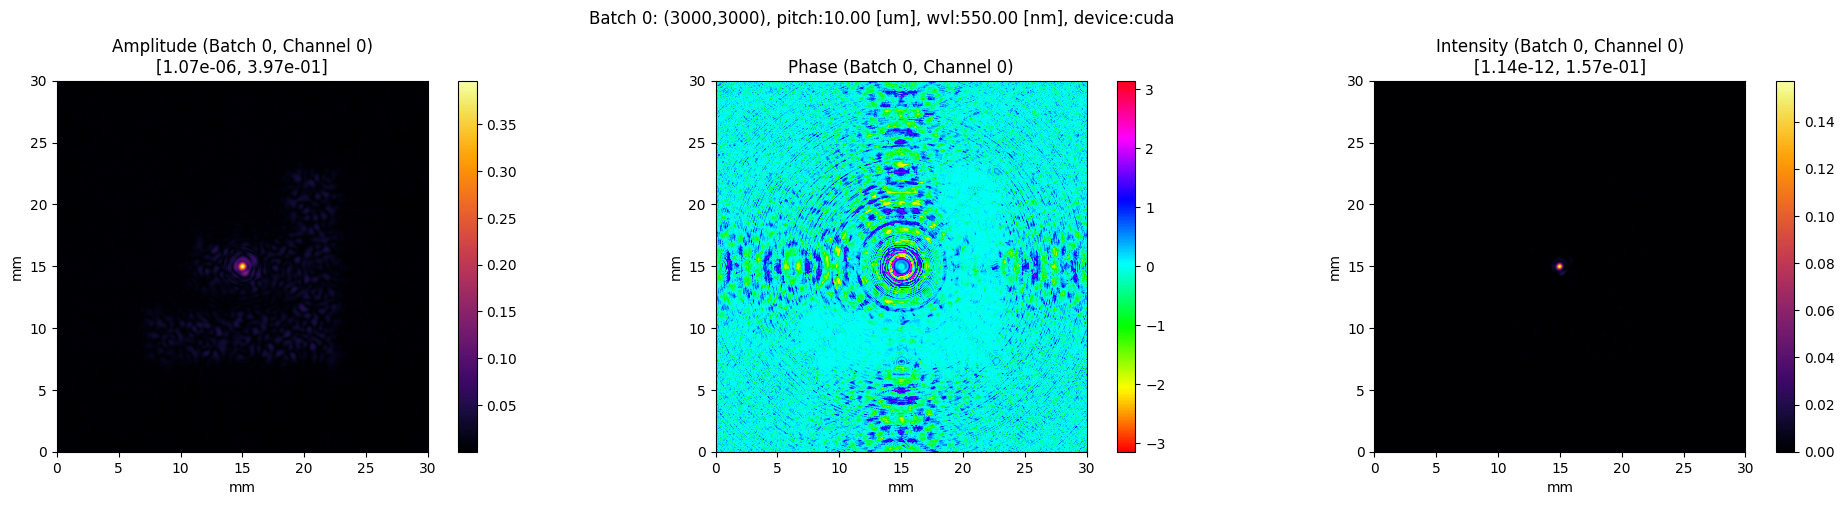

In [12]:
def simulate_pinhole(light, pinhole, object_distance, image_distance):
    out = propagator.forward(light, object_distance)
    out = pinhole.forward(out)
    out = propagator.forward(out, image_distance)

    return out

result = simulate_pinhole(object_light, pinhole, object_distance, image_distance)
result.visualize()

By applying a log scale to the amplitude, we can clearly observe the inverted shape of **F**!

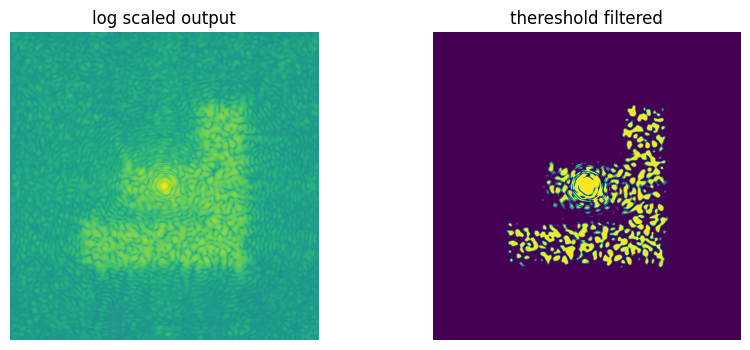

In [13]:
log_scaled = np.log(result.get_amplitude().cpu() + 1e-9).squeeze()
threshold = -4

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(log_scaled)
ax[0].axis('off')
ax[0].set_title('log scaled output')
ax[1].imshow(log_scaled > threshold)
ax[1].axis('off')
ax[1].set_title('thereshold filtered')

plt.show()

## 🧮 **Step 4: Unifrom Redundant Array**

Now, let's consider an aperture containing `multiple pinholes` instead of just one. In this case, the images corresponding to each pinhole will overlap on the image plane, creating a composite image. 

A sufficiently small pinhole can be approximated as a `delta function`, allowing us to express the observed image $P$ as:

### $P = O * A + N$

where:
- $P$ is the observed image,
- $O$ is the object,
- $A$ is the aperture function,
- $N$ represents noise.


The `Uniform Redundant Array (URA)` is a specialized aperture pattern designed for enhanced image reconstruction. One of its key properties is that its **self-correlation remains flat except for a single peak**. This characteristic improves the ability to recover the original object from the observed image by minimizing unwanted interference patterns.

In [14]:
pitch = 1 * um
R, C = 5000, 5000

object = generate_f_tensor(R, scale=10)
object_light = pado.light.Light((1, 1, R, C), pitch, wvl, object.to(device), device=device)
object_light.set_phase_random()

In [15]:
from pado.math import fft, ifft
import torch.nn.functional as F

def quadratic_residue(v, i):
    """
    Determines whether a given integer 'i' is a quadratic residue modulo 'v'.

    Parameters:
    v (int): The modulus.
    i (int): The number to check.

    Returns:
    int: 1 if 'i' is a quadratic residue modulo 'v', otherwise -1.
    """
    residues = {np.mod(x**2, v) for x in range(1, v)}
    return 1 if i in residues else -1

def ura_sequence(r, c):
    """
    Generates a Uniformly Redundant Array (URA) sequence.

    Parameters:
    r (int): Number of rows.
    c (int): Number of columns.

    Returns:
    torch.Tensor: A binary tensor of shape (r, c) representing the URA sequence.
    """
    ret = torch.ones((r, c))
    ret[:, 0] = 1
    ret[0, :] = 0

    for i in range(1, r):
        for j in range(1, c):
            ret[i, j] = 1 if quadratic_residue(r, i) * quadratic_residue(c, j) == 1 else 0
        
    return ret

def random_array(r, c):
    """
    Generates a random binary array of size (r, c).

    Parameters:
    r (int): Number of rows.
    c (int): Number of columns.

    Returns:
    torch.Tensor: A binary tensor of shape (r, c).
    """
    ret = (torch.rand(r, c) > 0.5).float()

    return ret

The code below visualizes both the `URA` and a `Random Array`. The distinctive pattern of the URA is a key characteristic.

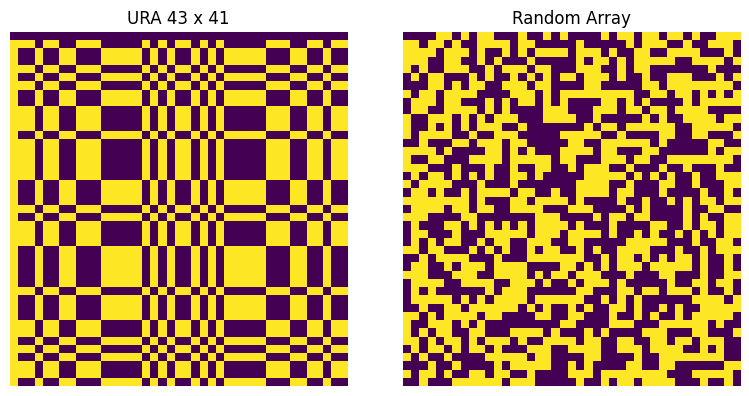

In [16]:
ura43 = ura_sequence(43, 41)
random_mask = random_array(43, 41)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(ura43)
ax[0].axis('off')
ax[0].set_title('URA 43 x 41')
ax[1].imshow(random_mask)
ax[1].axis('off')
ax[1].set_title('Random Array')

plt.tight_layout()
plt.show()

Now, let's examine the autocorrelation of the URA. 
Autocorrelation can be computed by correlating a tensor with itself, which is equivalent to convolution with a flipped kernel. 
Paod supports 2D Fourier Transform, inverse Fourier Transform, and convolution for this purpose.


In [31]:
def correlation(image, kernel, linear=True):
    """
    Computes the correlation between an image and a kernel using Fourier Transform.

    Parameters:
    image (torch.Tensor): The input image (2D tensor).
    kernel (torch.Tensor): The correlation kernel (2D tensor).
    linear (bool, optional): If True, applies zero-padding to handle linear correlation (default: True).

    Returns:
    torch.Tensor: The real part of the correlated output.
    """
    
    pad = (C//2, C//2, R//2, R//2) if linear else None

    kernel=torch.flip(kernel, dims=(-2, -1))

    image_fft = fft(image, pad_width=pad)
    kernel_fft = fft(kernel, pad_width=pad)

    return ifft(image_fft * kernel_fft, pad_width=pad).real

ura_autocorrelation = correlation(ura43, ura43, linear=False)
random_autocorrelation = correlation(random_mask, random_mask, linear=False)

In 2D autocorrelation, we extract only the center row for analysis. 
The autocorrelation of a `URA` is flat except for a `single peak`, whereas that of a `random array` does not exhibit this characteristic.

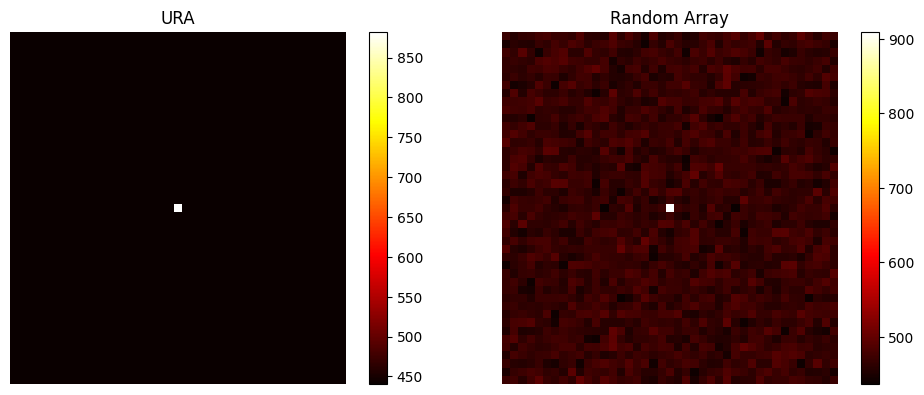

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ura_im = ax[0].imshow(ura_autocorrelation, cmap='hot')
random_im = ax[1].imshow(random_autocorrelation, cmap='hot')

fig.colorbar(ura_im, ax=ax[0])
fig.colorbar(random_im, ax=ax[1])

ax[0].axis('off')
ax[0].set_title('URA')
ax[1].axis('off')
ax[1].set_title('Random Array')

plt.tight_layout()
plt.show()

Using a `URA` sequence, we will design a pinhole aperture that takes advantage of the URA's `unique self-correlation properties`. This aperture pattern ensures that overlapping images can be deconvolved more effectively, improving image reconstruction quality.

In [34]:
def generate_pinhole_mask(binary_array, d, k=1.0):
    """
    Generates a pinhole mask based on a given binary array.

    The function creates a 2D mask where pinholes are placed at positions
    specified by the binary array. Each pinhole is circular with diameter `d`.
    The spacing between pinholes is determined by `d * 1.33 * k`.

    Parameters:
    binary_array (torch.Tensor): A binary matrix (r x c) indicating pinhole positions.
    d (float): The diameter of each pinhole in physical units.
    k (float, optional): A scaling factor that adjusts the pinhole spacing (default is 1.0).

    Returns:
    torch.Tensor: A 2D mask of shape (R, C) representing the pinhole array.
    """

    pinhole_mask = torch.zeros((R, C))
    pixel_d = int(d / pitch)
    spacing = d * 1.33 * k 

    r, c = binary_array.shape
    
    x_start = -((c - 1) * spacing) / 2
    y_start = -((r - 1) * spacing) / 2
    
    x_positions = torch.linspace(x_start, -x_start, c)
    y_positions = torch.linspace(y_start, -y_start, r)

    xx, yy = torch.meshgrid(torch.linspace(-d/2, d/2, pixel_d), torch.linspace(-d/2, d/2, pixel_d), indexing='xy')
    patch = (xx ** 2 + yy ** 2 <= (d / 2) ** 2)
    
    indices = [(i, j) for i in range(r) for j in range(c) if binary_array[i, j]]

    for i, j in indices:
        dx, dy = x_positions[j], y_positions[i]

        off_x, off_y = int(C / 2 + dx / pitch - pixel_d / 2), int(R / 2 + dy / pitch - pixel_d / 2)
        pinhole_mask[off_y: off_y + pixel_d, off_x: off_x + pixel_d] = patch
    
    return pinhole_mask

Now, let's verify this using a real image.

In [35]:
minimum_distance = calc_min_depth(R, wvl, pitch)
object_distance = 2 * minimum_distance
image_distance = 0.5 * minimum_distance

object_image_ratio = image_distance / object_distance
aperture_image_ratio = (object_distance + image_distance) / object_distance
pinhole_diameter = np.sqrt(image_distance * wvl)

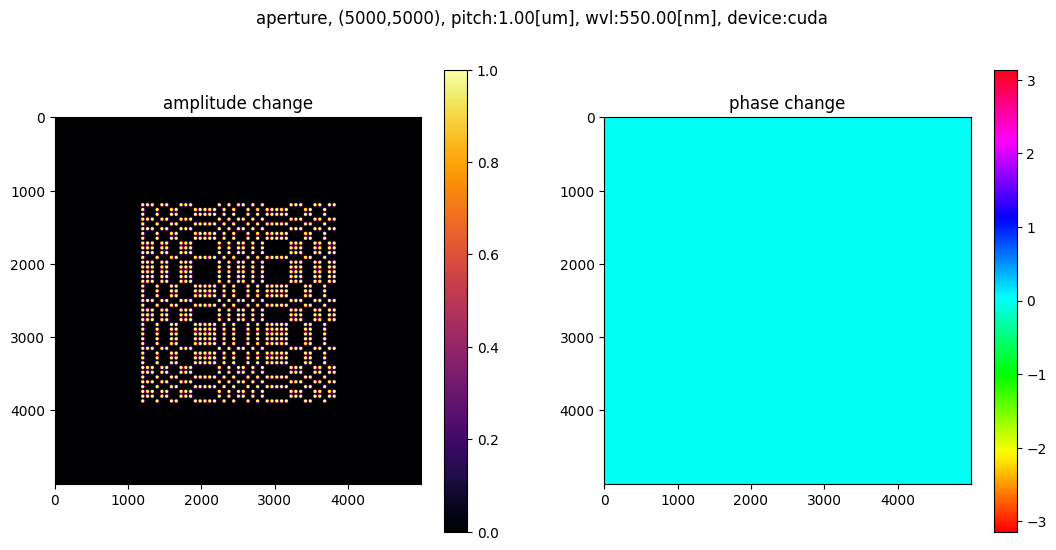

In [36]:
ura_mask = generate_pinhole_mask(ura43, pinhole_diameter)
ura_mask_propagated = generate_pinhole_mask(ura43, pinhole_diameter, aperture_image_ratio)
ura_pinhole = pado.optical_element.Aperture((1, 1, R, C), pitch, 0, 'circle', wvl, device=device)
ura_pinhole.set_amplitude_change(ura_mask.to(device))
ura_pinhole.visualize()

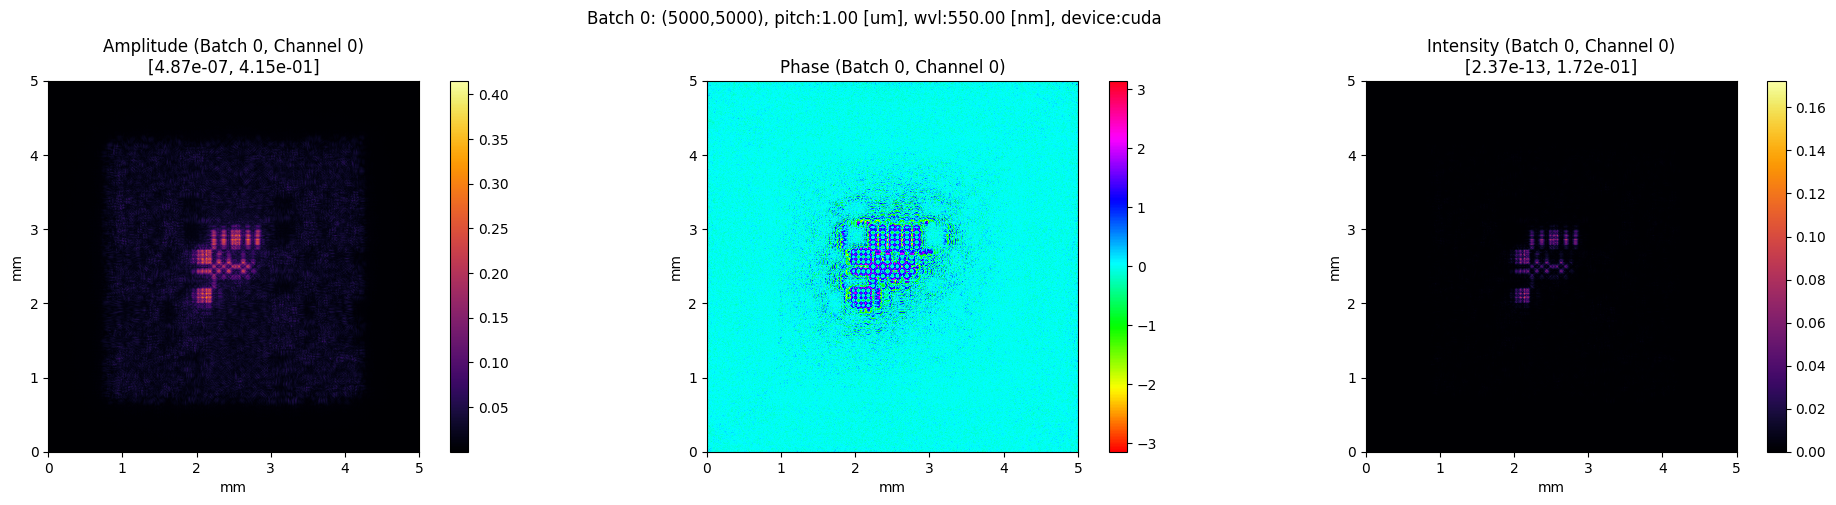

In [37]:
ura_out = simulate_pinhole(object_light, ura_pinhole, object_distance, image_distance)
ura_out.visualize()

In [38]:
def center_crop(x, crop_factor):
    """
    Performs center cropping on a 2D image and resizes back to the original shape.

    Parameters:
    x (torch.Tensor): Input tensor
    crop_factor (float): The fraction of the image to retain

    Returns:
    torch.Tensor: The cropped and resized image of the same shape as the input.
    """

    h, w = x.shape[-2:]

    crop_y, crop_x = int(h * crop_factor), int(w * crop_factor)

    center_x, center_y = w // 2, h // 2
    crop_x1, crop_x2 = center_x - crop_x // 2, center_x + crop_x // 2
    crop_y1, crop_y2 = center_y - crop_y // 2, center_y + crop_y // 2
    ret = x[..., crop_y1:crop_y2, crop_x1:crop_x2]

    ret = F.interpolate(ret, (h, w))

    return ret

reconstructed = correlation(ura_out.get_amplitude().cpu(), ura_mask_propagated) ** 7
reconstructed = torch.flip(reconstructed, dims=(-2, -1))
reconstructed /= reconstructed.max()

reconstructed = center_crop(reconstructed, object_image_ratio).squeeze()
reconstructed = reconstructed ** 7

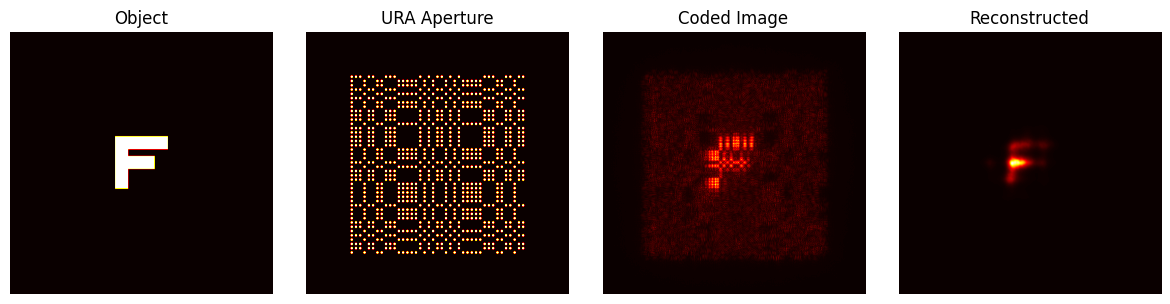

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(object.squeeze(), cmap='hot')
axes[1].imshow(ura_mask_propagated.squeeze(), cmap='hot')
axes[2].imshow(ura_out.get_amplitude().cpu().squeeze(), cmap='hot')
axes[3].imshow(reconstructed.squeeze(), cmap='hot')
axes[0].set_title('Object')
axes[1].set_title('URA Aperture')
axes[2].set_title('Coded Image')
axes[3].set_title('Reconstructed')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.tight_layout()
plt.show()